# CAB420 Assignment 3 Class Activation Mappings

This notebook is an exploration in class activation mappings produced by a CNN which
has been trained to classify images in three broad categories.

These categories are as follows:
* air animals
* land animals
* water animals

The classifier is trained on a small subset of the Caltech256 dataset. The subset
contains images from 27 classes in total (9 from each category).

By Christopher Ayling

Adapted from content from http://www.fast.ai/

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# Building Model

In [11]:
PATH = "data/caltech256_A3/"
sz = 224
arch = resnet34
bs = 64
num_classes = 3

In [8]:
m = arch(True)

In [12]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [13]:
m = nn.Sequential(*children(m)[:-2],
                 nn.Conv2d(512, num_classes, 3, padding=1),
                 nn.AdaptiveAvgPool2d(1), Flatten(),
                 nn.LogSoftmax())

In [14]:
m

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [15]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, test_name="test", test_with_labels=True)

In [16]:
print("train sz: {0}\nval sz: {1}\ntest sz: {2}".format(len(data.trn_ds), len(data.val_ds), len(data.test_ds)))

train sz: 1991
val sz: 458
test sz: 413


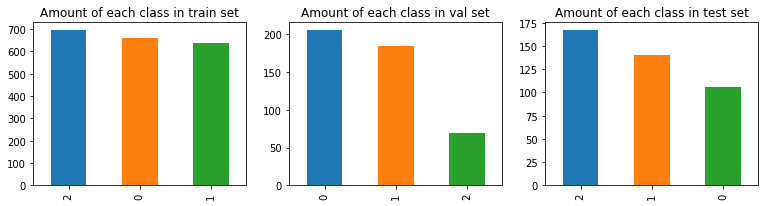

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 3))
pd.Series(data.trn_ds.y).value_counts().plot.bar(title="Amount of each class in train set", ax=axes[0])
pd.Series(data.val_ds.y).value_counts().plot.bar(title="Amount of each class in val set", ax=axes[1]),
pd.Series(data.test_ds.y).value_counts().plot.bar(title="Amount of each class in test set", ax=axes[2])

In [18]:
learn = ConvLearner.from_model_data(m, data)

In [9]:
learn.freeze_to(-4)

 78%|███████▊  | 25/32 [00:06<00:01,  3.58it/s, loss=6.7] 


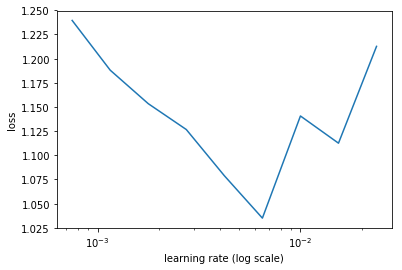

In [10]:
learn.lr_find()
learn.sched.plot()

In [11]:
learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                 
    0      37.217134  11.480844  0.917031  
    1      18.675371  10.801526  0.927948                 



[10.80152632367663, 0.9279475985135573]

In [12]:
learn.fit(0.01, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      5.338181   7.552607   0.938865  



[7.552606905391643, 0.9388646283003961]

# Model Evaluation

In [13]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
print("accuracy", accuracy_np(probs, y))

accuracy 0.9366812227074236                  


[[198   2   5]
 [  7 173   4]
 [  4   7  58]]


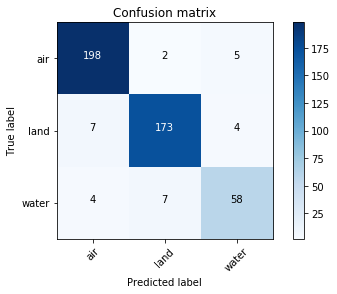

In [14]:
prds = np.argmax(probs, axis=1)
prbs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, prds)
plot_confusion_matrix(cm, data.classes)

# Class Actiation Mappings

Generate heatmaps of images representing what parts the CNN is interested in.

In [23]:
def get_label(preds):
    return data.classes[np.argmax(preds)]

In [15]:
# ignore scipy resize deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [16]:
class SaveFeatures():
    features=None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def remove(self):
        self.hook.remove()

In [17]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)

In [90]:
def get_cam_overlay(img):
    img = val_tfms(img)
    
    mo = learn.model
    sfs = [SaveFeatures(o) for o in [mo[-7], mo[-6], mo[-5], mo[-4]]]
    py = learn.predict_array(img[None])
    label = get_label(np.exp(py))
    for o in sfs: o.remove()
        
    img = scipy.misc.imresize(img, (sz, sz))
    py = np.exp(to_np(py)[0])
    feat = np.maximum(0, to_np(sfs[3].features[0]))
    f2 = np.dot(np.rollaxis(feat, 0, 3), py)
    f2 -= f2.min()
    f2 /= f2.max()
    return scipy.misc.imresize(f2, (sz, sz))

def get_cam_overlay_from_path(path): return get_cam_overlay(open_image(path))

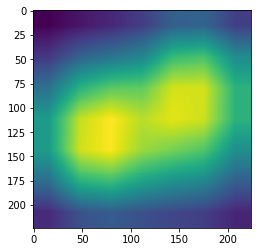

In [92]:
plt.imshow(get_cam_overlay_from_path('test.jpg'))

In [66]:
def get_cam(img):
    img = val_tfms(img)
    
    mo = learn.model
    sfs = [SaveFeatures(o) for o in [mo[-7], mo[-6], mo[-5], mo[-4]]]
    py = learn.predict_array(img[None])
    label = get_label(np.exp(py))
    for o in sfs: o.remove()
        
    img = scipy.misc.imresize(img, (sz, sz))
    plt.imshow(img)    
    
    py = np.exp(to_np(py)[0])
    feat = np.maximum(0, to_np(sfs[3].features[0]))
    f2 = np.dot(np.rollaxis(feat, 0, 3), py)
    f2 -= f2.min()
    f2 /= f2.max()
    
    plt.imshow(scipy.misc.imresize(f2, (sz, sz)), alpha=0.5, cmap='hot')
    plt.title(label + " animal")
    
def get_cam_from_path(path): get_cam(open_image(path))

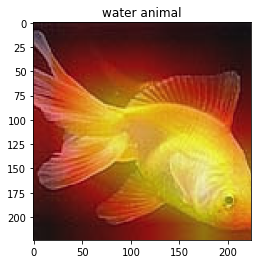

In [67]:
get_cam_from_path(PATH+folder_source(PATH, 'test')[0][300])

In [47]:
p = PATH + folder_source(PATH, 'test')[0][300]
preds = learn.predict_array(val_tfms(open_image(p))[None])
get_label(np.exp(preds)), p

('water', 'data/caltech256_A3/test/water/087_0059.jpg')

In [117]:
def get_label_from_path(path):
    preds = learn.predict_array(val_tfms(open_image(path))[None])
    return get_label(np.exp(preds))

In [80]:
def get_examples(class_name, folder='test'):
    return list(map(lambda f: f"{PATH}{folder}/{class_name}/{f}", os.listdir(f"{PATH}{folder}/{class_name}/")))

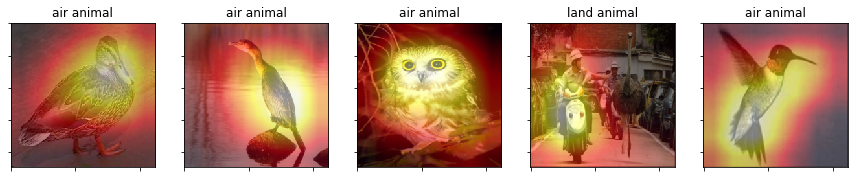

In [119]:
exs = get_examples("air")[:5]

f, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

for ax, ex in zip(axes, exs):
    ax.imshow(scipy.misc.imresize(open_image(ex), (sz, sz)))
    ax.imshow(get_cam_overlay_from_path(ex), alpha=0.5, cmap='hot')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(get_label_from_path(ex) + " animal")

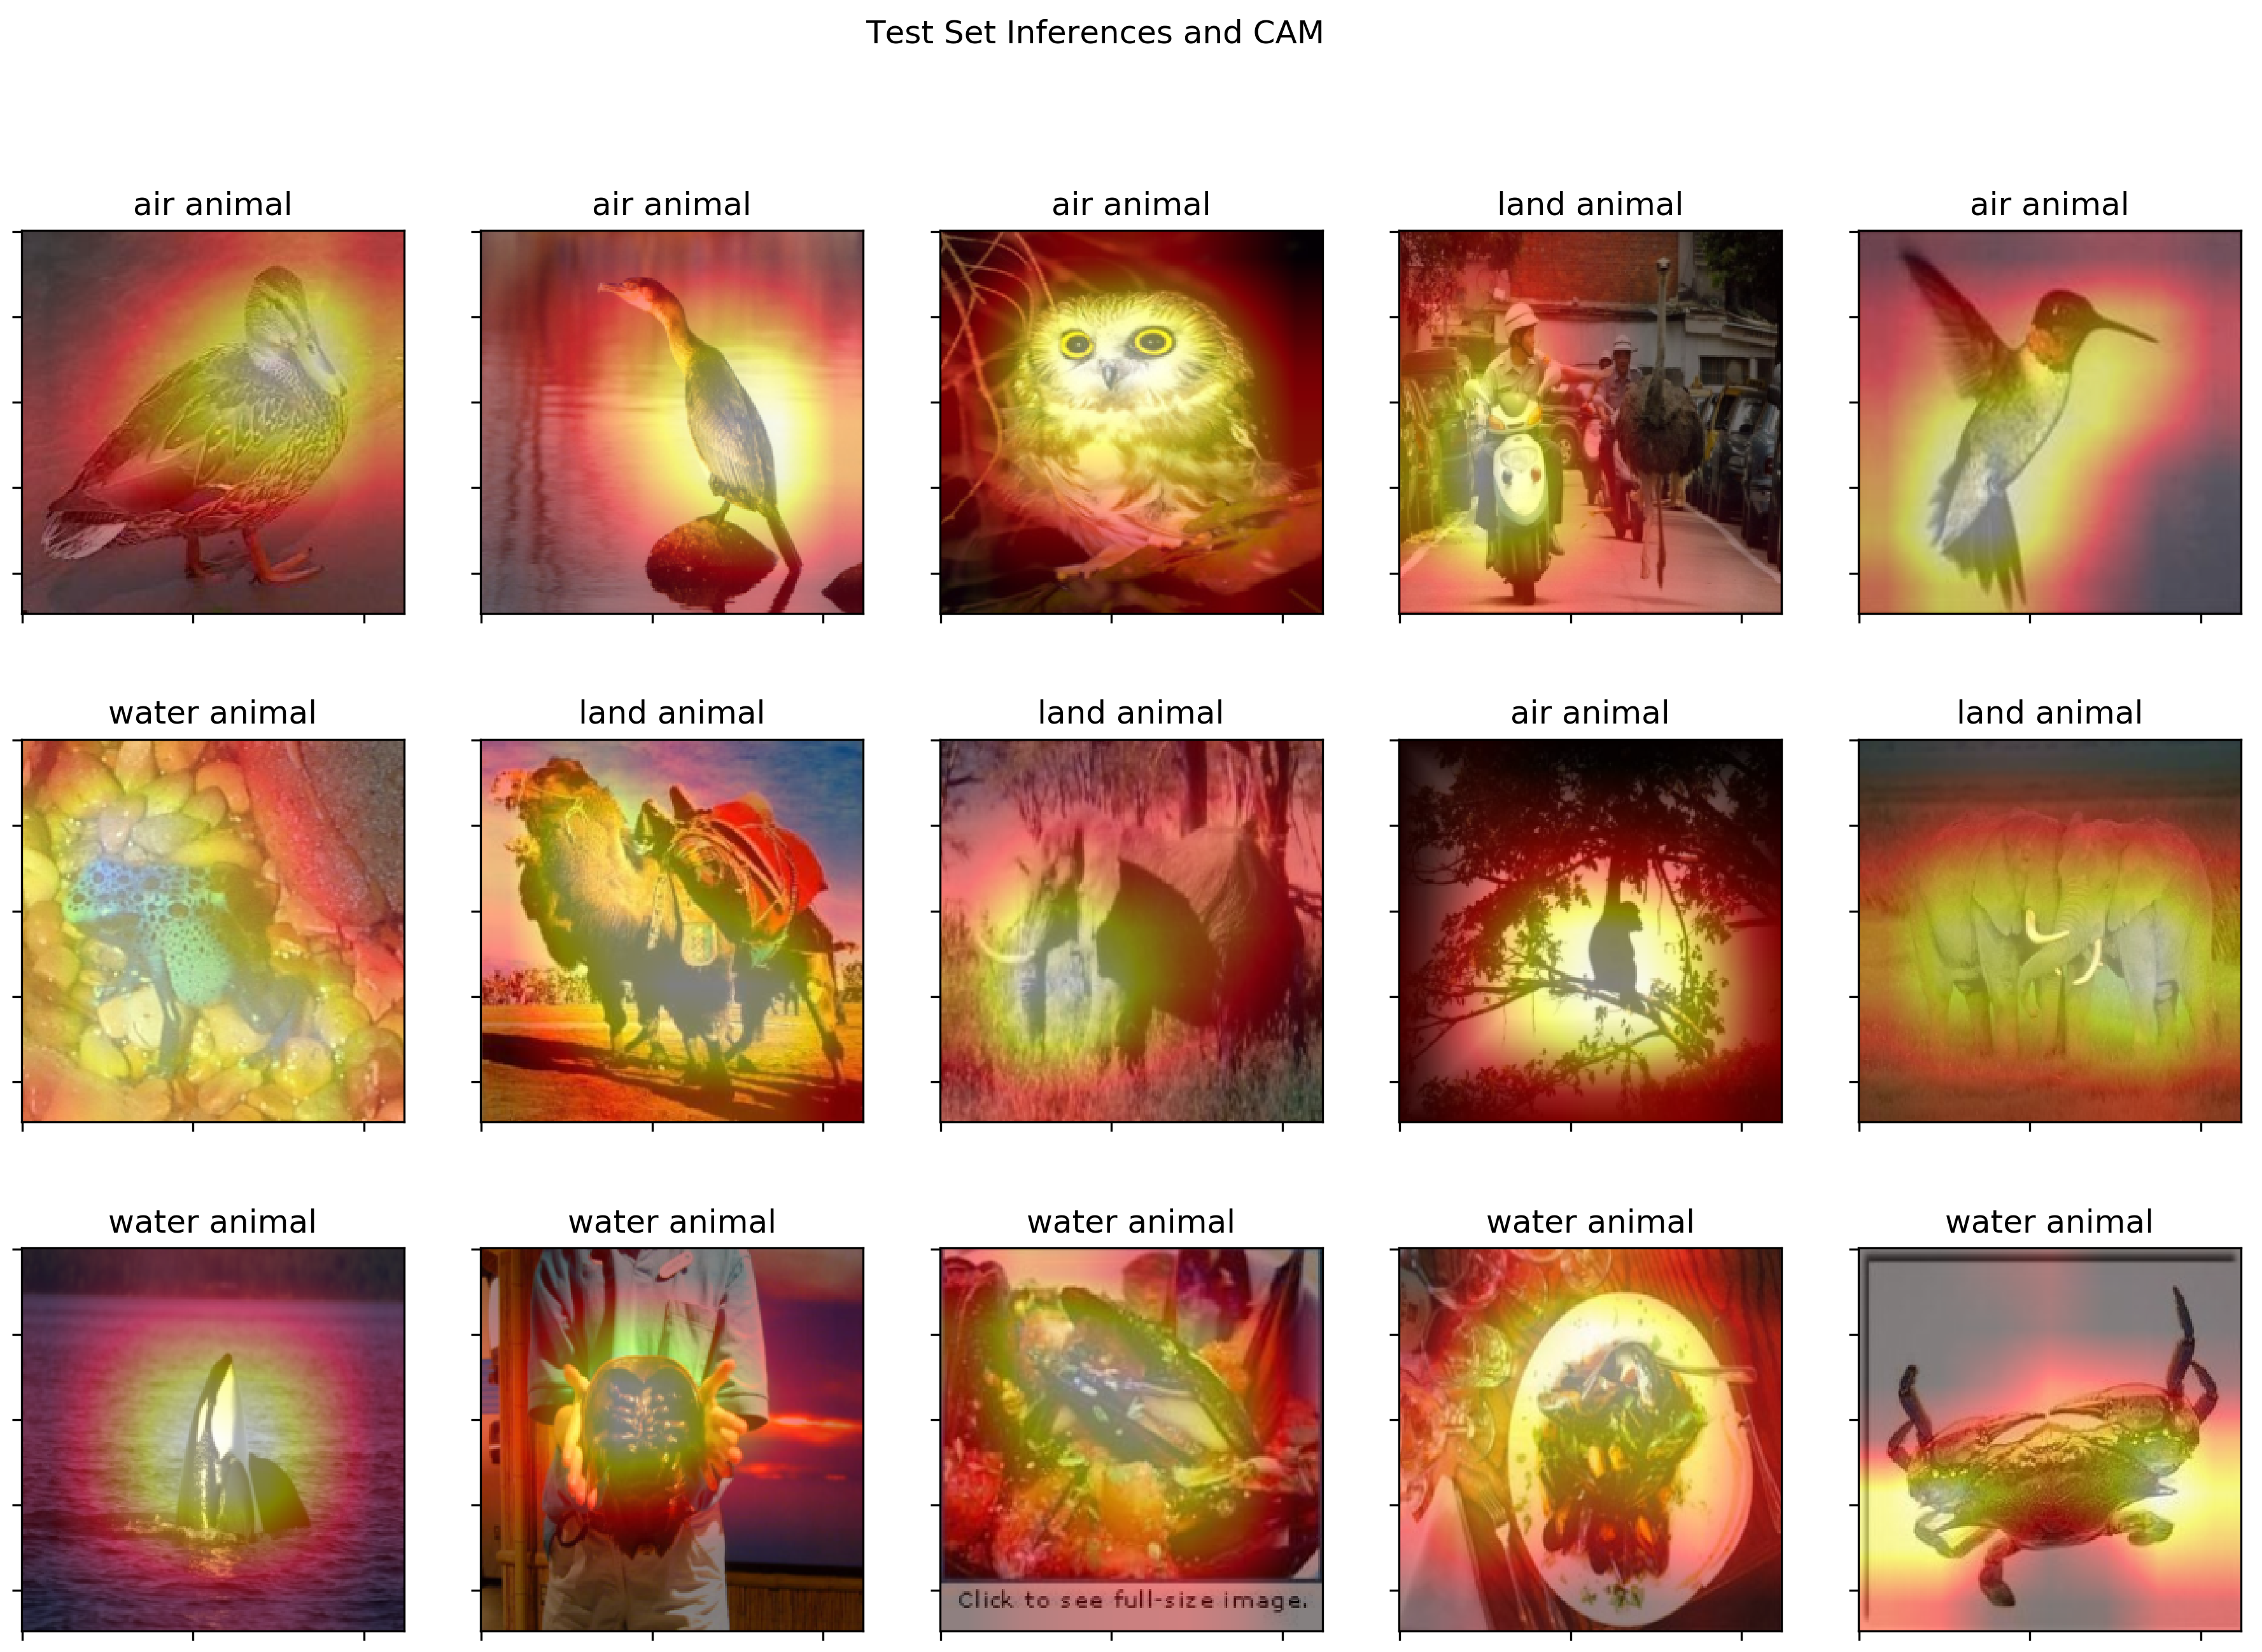

In [136]:
f, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10), dpi=300)
f.suptitle("Test Set Inferences and CAM")

for row, cls in zip(axes, data.classes):
    for col, img in zip(row, get_examples(cls)):
        col.imshow(scipy.misc.imresize(open_image(img), (sz, sz)))
        col.imshow(get_cam_overlay_from_path(img), alpha=0.5, cmap='hot')
        col.set_yticklabels([])
        col.set_xticklabels([])
        col.set_title(get_label_from_path(img) + " animal")